In [1]:
from lusidtools.jupyter_tools import toggle_code

"""Loading and caculating returns

Demonstration of how to load and calculate returns on composite portfolios in LUSID

Attributes
----------
Returns
Composite portfolios
"""

toggle_code("Toggle Docstring")

In [2]:
# %load_ext lab_black
# %load_ext nb_black

# 1. Loading and calculating composite returns in LUSID

In this notebook we show composite returns for two portfolios - a UK Active Equity and a UK Active Fixed Income portfolio. We show returns from 1 Jan 2014 to 31 Dec 2016.

# 2. Setup

In [3]:
# Import general purpose packages
import os
import json
import pandas as pd
import numpy as np
import datetime
import pytz
import warnings

warnings.filterwarnings("ignore", module="matplotlib*")

import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from pandas import json_normalize

# Import lusid specific packages
import lusid
import lusid.models as models

from lusid.utilities import ApiClientFactory
from lusidjam.refreshing_token import RefreshingToken

# Set display configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 3500)
pd.set_option("max_colwidth", 20)

# Use line magic function to enable matplotlib to work interactively with iPython
%matplotlib inline

# Set style to fivethirtyeight to create clean and clear looking graphs
plt.style.use("fivethirtyeight")

# Define a dictionary containing default plotting configurations
params = {
    "legend.fontsize": "small",
    "figure.figsize": (12, 4.5),
    "axes.labelsize": "small",
    "axes.titlesize": "medium",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
}

plt.rcParams.update(params)

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

# Initiate an API Factory which is the client side object for interacting with LUSID APIs
api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename=secrets_path,
    app_name="LusidJupyterNotebook",
)

api_status = pd.DataFrame(
    api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().to_dict()
)

display(api_status)

,api_version,build_version,excel_version,links
0,v0,0.6.6850.0,0.5.2126,{'relation': 'Re...


In [4]:
# Define a scope to hold data

scope = "compositeDemo"

In [5]:
# define the three portfolios

portfolio_codes = ["ukActiveEquity", "ukActiveFI", "composite"]

equity_portfolio, fi_portfolio, composite_portfolio = (
    portfolio_codes[0],
    portfolio_codes[1],
    portfolio_codes[2],
)

In [6]:
# Define the APIs we use

transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
portfolios_api = api_factory.build(lusid.api.PortfoliosApi)
relationship_definition_api = api_factory.build(lusid.api.RelationshipDefinitionsApi)
relationships_api = api_factory.build(lusid.api.RelationshipsApi)

In [7]:
# Define dates
start_date = datetime(year=2020, month=1, day=2, tzinfo=pytz.UTC).isoformat
number_of_days = 366

# 3. Portfolio and relationships setup

## 3.1 Create three portfolios

1. A UK Equity Portfolio
2. A UK Fixed Income Portfolio
3. A Composite Portfolio

In [8]:
for port in portfolio_codes:

    try:

        response = transaction_portfolios_api.create_portfolio(
            scope=scope,
            create_transaction_portfolio_request=models.CreateTransactionPortfolioRequest(
                display_name=port, code=port, created="2013-12-30", base_currency="GBP"
            ),
        )
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

Could not create a portfolio with id ukActiveEquity because it already exists in scope compositeDemo.
Could not create a portfolio with id ukActiveFI because it already exists in scope compositeDemo.
Could not create a portfolio with id composite because it already exists in scope compositeDemo.


## 3.2 Create a relationship definition

Create a relationship to represent the composite

In [9]:
relationship_scope = "default"
reationship_code = "CompositeMember"

In [10]:
try:

    relationship_definition_api.create_relationship_definition(
        create_relationship_definition_request=models.CreateRelationshipDefinitionRequest(
            scope=relationship_scope,
            code=reationship_code,
            source_entity_type="Portfolio",
            target_entity_type="Portfolio",
            display_name="Relationship for Composite Returns",
            outward_description="Relationship for Composite Returns",
            inward_description="Relationship for Composite Returns",
        )
    )

except lusid.ApiException as e:
    print(json.loads(e.body)["title"])

Relation definition with scope 'default' and code 'CompositeMember' already exists


## 3.3 Create relationship between composite and investment portfolios

In [11]:
for portfolio in [equity_portfolio, fi_portfolio]:

    relationships_api.create_relationship(
        scope=relationship_scope,
        code=reationship_code,
        create_relationship_request=models.CreateRelationshipRequest(
            source_entity_id={"scope": scope, "code": composite_portfolio},
            target_entity_id={"scope": scope, "code": portfolio},
        ),
    )

# 4. Load returns

## 4.1 Load returns from CSV file into DataFrame

In [12]:
returns_df = pd.read_csv(
    "data/composite_performance_data.csv", dtype={"daily_returns": np.int64}
)
returns_df["date"] = pd.to_datetime(returns_df["date"], format="%d/%m/%Y")
returns_df = returns_df.rename(
    columns={"mv": "market_value", "returns": "daily_returns"}
)

In [13]:
uk_equity_returns = returns_df[returns_df["portfolio"] == "uKEquity"].copy()
fi_equity_returns = returns_df[returns_df["portfolio"] == "uKFixedIncome"].copy()

# 4.2 Load returns from DataFrame into LUSID

In [14]:
from_effective_at = "2014-01-01"
to_effective_at = "2015-12-31"
return_code = "daily_return"
list_of_porfolios = [equity_portfolio, fi_portfolio, composite_portfolio]

> <b> NOTE: We have truncated the upsert to 10 rows. Remove the cell below if you want to load all 4500+ rows of daily returns.</b>

In [15]:
uk_equity_returns = uk_equity_returns[:10]
fi_equity_returns = fi_equity_returns[:10]

In [16]:
for portfolio, df in [
    (equity_portfolio, uk_equity_returns),
    (fi_portfolio, fi_equity_returns)]:

    time_series_of_returns = [
        models.PerformanceReturn(
            effective_at=row["date"].isoformat()[:10],
            rate_of_return=row["daily_returns"],
            opening_market_value=row["market_value"],
            period="Daily",
        )
        for _, row in df.iterrows()
    ]

    upsert_returns = portfolios_api.upsert_portfolio_returns(
        scope=scope,
        code=portfolio,
        return_code=return_code,
        return_scope=scope,
        performance_return=time_series_of_returns,
    )

# 5. Get returns out of LUSID

# 5.1 Call a table of returns data for our three portfolios 

In [17]:
def get_returns_since_inc(portfolio_code):

    returns = portfolios_api.get_portfolio_aggregate_returns(
        scope=scope,
        code=portfolio_code,
        return_scope=scope,
        return_code=return_code,
        from_effective_at=from_effective_at,
        to_effective_at=to_effective_at,
        period="Daily",
        output_frequency="Daily",
        metrics=["SINCE(2014-01-01)",],
    )

    return returns

In [18]:
all_summary_df = pd.DataFrame(
    columns=["effective_at", "metrics_value.SINCE(2014-01-01)"]
)


for portfolio in list_of_porfolios:

    portfolio_summary_df = pd.DataFrame(
        columns=["effective_at", "metrics_value.SINCE(2014-01-01)"]
    )

    returns = get_returns_since_inc(portfolio)

    for item in returns.values:

        normalize_json = json_normalize(item.to_dict())
        normalize_json = normalize_json.set_index("effective_at").copy()
        portfolio_summary_df = portfolio_summary_df.append(normalize_json)

    all_summary_df = all_summary_df.join(
        portfolio_summary_df, rsuffix=f"{portfolio}", on="effective_at", how="outer"
    )

In [19]:
summary_columns = {
    "metrics_value.SINCE(2014-01-01)ukActiveEquity": "ukActiveEquity",
    "metrics_value.SINCE(2014-01-01)ukActiveFI": "ukActiveFI",
    "metrics_value.SINCE(2014-01-01)composite": "composite",
}

In [20]:
all_summary_df = (
    all_summary_df[list(summary_columns.keys())].rename(columns=summary_columns).copy()
)

In [21]:
all_summary_df.head(10)

,ukActiveEquity,ukActiveFI,composite
2014-01-02 00:00:00+00:00,-0.00058,0.00922,0.00597
2014-01-03 00:00:00+00:00,0.00321,0.00065,0.00159
2014-01-04 00:00:00+00:00,0.00936,0.00410,0.00593
2014-01-05 00:00:00+00:00,0.02007,0.00401,0.00946
2014-01-06 00:00:00+00:00,0.03400,0.01163,0.01917
2014-01-07 00:00:00+00:00,0.04182,0.00333,0.01622
2014-01-08 00:00:00+00:00,0.04823,-0.00669,0.01160
2014-01-09 00:00:00+00:00,0.04923,-0.00596,0.01242
2014-01-10 00:00:00+00:00,0.04858,-0.00988,0.00955
2014-01-11 00:00:00+00:00,0.04074,-0.00206,0.01240


## 5.2 Plot the results

In [22]:
def time_series_performance():
    ts_performance = all_summary_df.plot(y=["ukActiveEquity", "ukActiveFI", "composite"], figsize=(12, 9))
    ts_performance.set_title(
        f"Performance since 2014-01-01",
        fontsize="large",
    )
    ts_performance.set_ylabel("Performance in %", fontsize="large")
    ts_performance.set_xlabel("Days", fontsize="large")
    ts_performance.legend(prop={"size": 12})

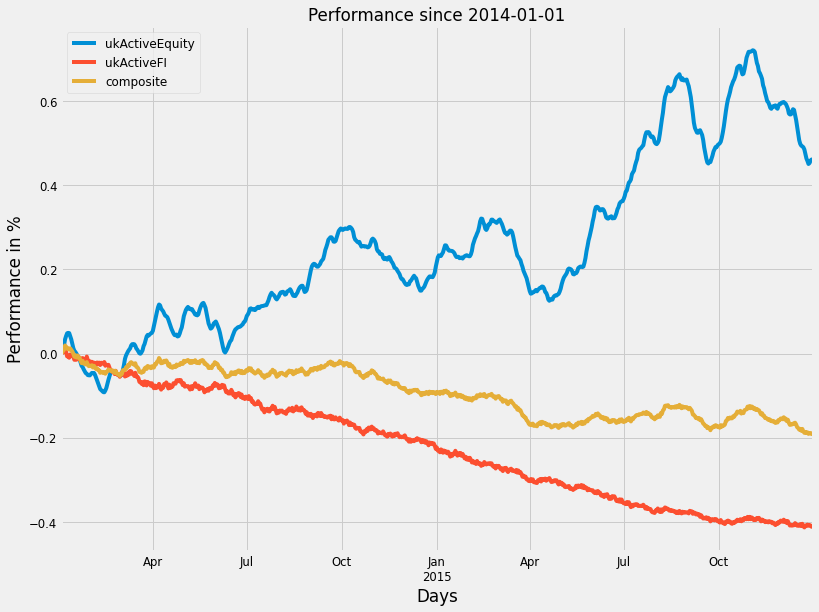

In [23]:
time_series_performance()